## Top-level Global Var

In [1]:
DEBUG = 8

## Imports

In [2]:
import argparse
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import os
from os.path import dirname
import random
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import tqdm

if DEBUG>0:
    from utils.models1 import Classifier
else:
    from utils.models import Classifier
from utils.dataset import NCaltech101
from utils.loader import Loader
from utils.train_eval import train_one_epoch, eval_one_epoch

if DEBUG>=8:
    if DEBUG==9:
        seed = 1587382387
    else:
        import time
        seed = int( time.time())
    print("Seed: %d" % seed)
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

Seed: 1587514549


In [3]:
class FLAGS:
    # To use N-Caltech101 data, uncomment 4 lines below
    validation_dataset = 'N-Caltech101/validation'
    training_dataset = 'N-Caltech101/training'
    height = 180
    width = 240
    # To use celeX data, uncomment 4 lines below
    # validation_dataset = 'celeX_files/npy'
    # training_dataset = 'celeX_files/npy'
    # height = 800
    # width = 1280
    
    log_dir = 'log/temp'
    device = 'cuda'
    num_workers = 8
    pin_memory = True
    batch_size = 16
    num_epochs = 60
    save_every_n_epochs = 5
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"----------------------------\n"
                  f"Starting training with \n"
                  f"height: {self.height}\n"
                  f"width: {self.width}\n"
                  f"num_epochs: {self.num_epochs}\n"
                  f"batch_size: {self.batch_size}\n"
                  f"device: {self.device}\n"
                  f"log_dir: {self.log_dir}\n"
                  f"training_dataset: {self.training_dataset}\n"
                  f"validation_dataset: {self.validation_dataset}\n"
                  f"num_workers: {self.num_workers}\n"
                  f"pin_memory: {self.pin_memory}\n"
                  f"----------------------------")

In [4]:
flags = FLAGS()
dim = (flags.height, flags.width)

# datasets, add augmentation to training set
training_dataset = NCaltech101(flags.training_dataset, augmentation=True, resolution=dim)
validation_dataset = NCaltech101(flags.validation_dataset, resolution=dim)

datasetClasses = training_dataset.getClasses()

# construct loader, handles data streaming to gpu
training_loader = Loader(training_dataset, flags, device=flags.device)
validation_loader = Loader(validation_dataset, flags, device=flags.device)

# model, and put to device
model = Classifier(device=flags.device, dimension=dim)
model = model.to(flags.device)

# optimizer and lr scheduler
optimizerSelect = 'adam'
if optimizerSelect == 'sgd':
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, momentum=0.9, weight_decay=1e-5)
elif optimizerSelect == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

----------------------------
Starting training with 
height: 180
width: 240
num_epochs: 60
batch_size: 16
device: cuda
log_dir: log/temp
training_dataset: N-Caltech101/training
validation_dataset: N-Caltech101/validation
num_workers: 8
pin_memory: True
----------------------------


tensor([ 1, 85, 50, 16,  3, 69, 31,  3, 99, 55, 86, 26,  1,  2, 75,  5])


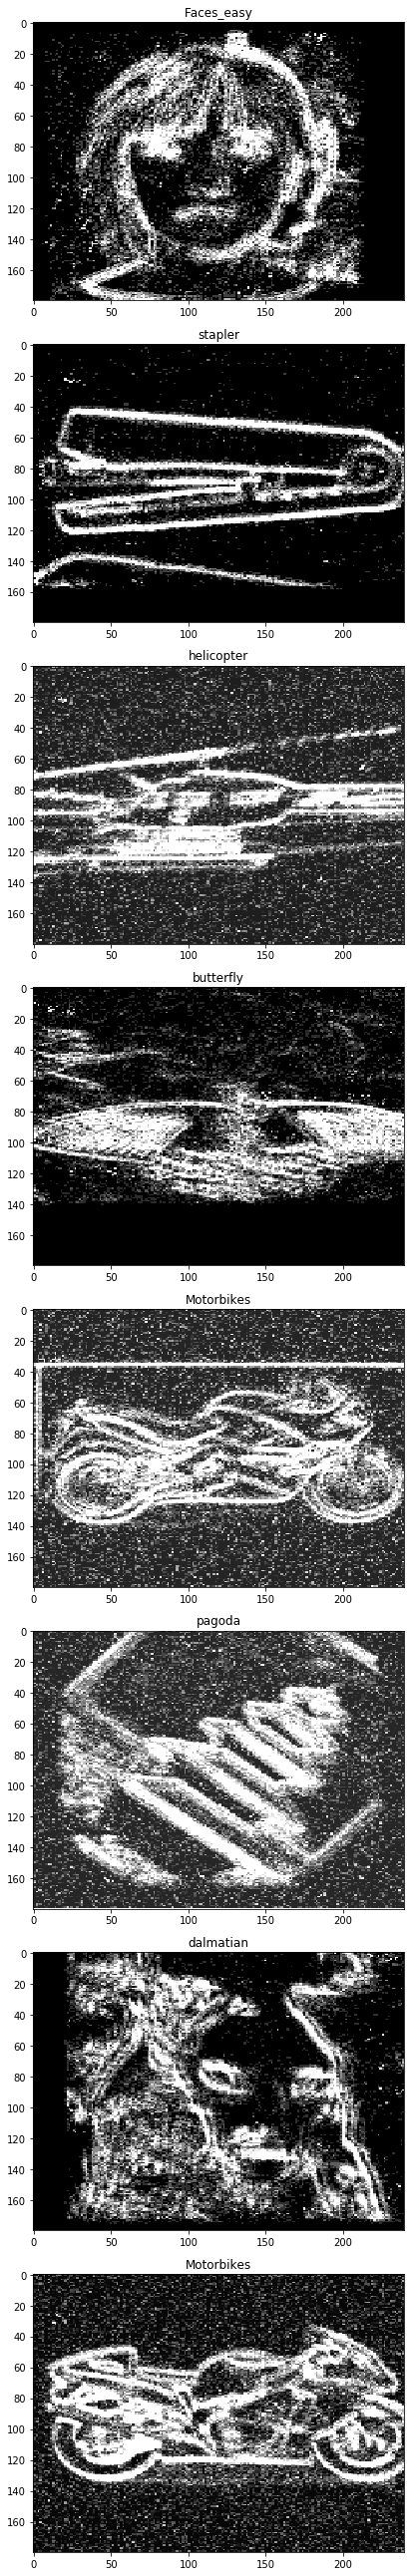

In [5]:
""" Visualization of training set """
itr = iter(validation_loader)
events, labels = next(itr)
model.setMode(0)
preprocessed = model.quantization_layer.forward(events)
preprocessed = model.crop_and_resize_to_resolution(preprocessed, dim)
# preprocessed = model.medianFilter(preprocessed)
preprocessed = preprocessed.cpu().numpy()

print(labels)

fig = plt.figure(figsize=(18, 36))
ax = []
rows = 8
columns = 1
for i in range(rows * columns):
    ax.append( fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title( datasetClasses[ labels[i].item()])
    plt.imshow(preprocessed[i][0], cmap='gray', vmin=0, vmax=1)
plt.tight_layout()
plt.show()

tensor([ 5, 48, 19, 19, 31,  2,  3, 94, 90, 47,  3, 55,  1, 16,  0, 15])


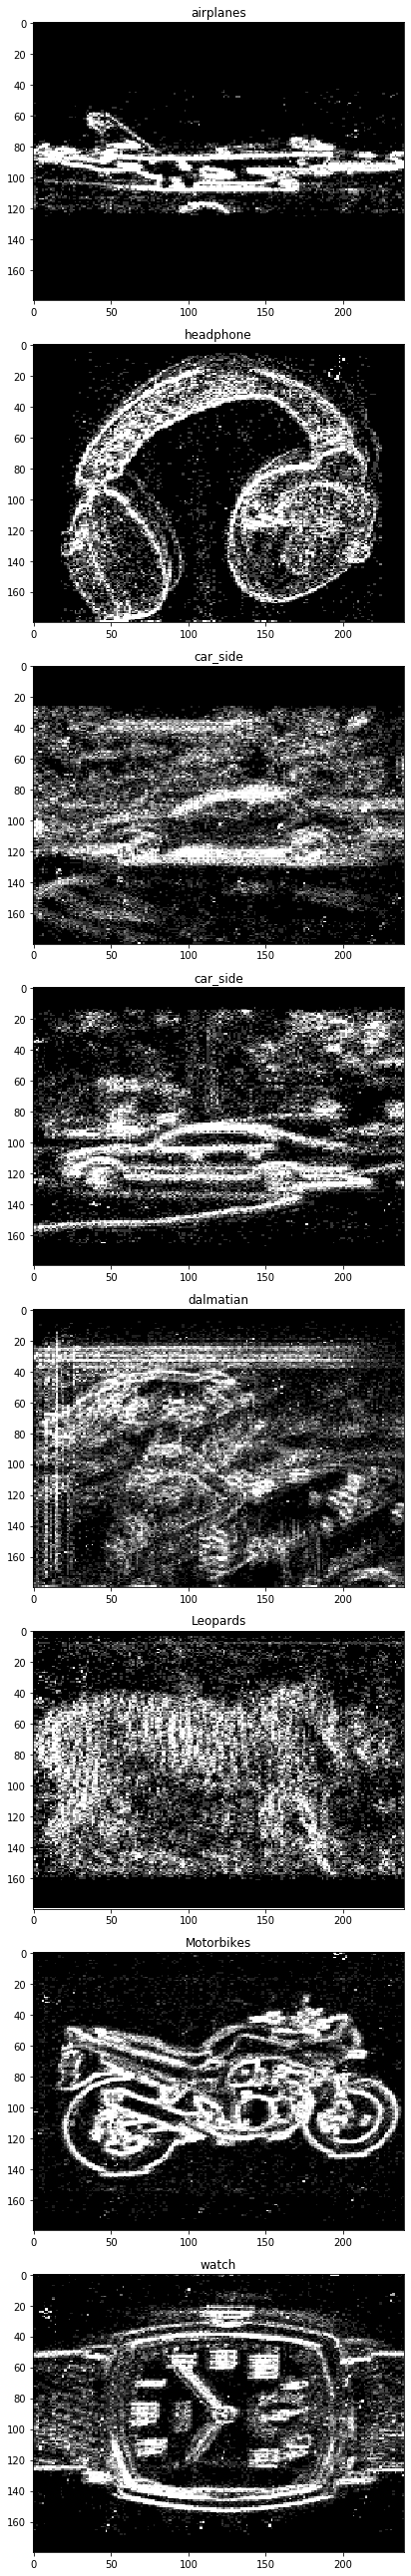

In [6]:
""" Visualization of validation set """
itr = iter(validation_loader)
events, labels = next(itr)
model.setMode(1)
preprocessed = model.quantization_layer.forward(events)
preprocessed = model.crop_and_resize_to_resolution(preprocessed, dim)
# preprocessed = model.medianFilter(preprocessed)
preprocessed = preprocessed.cpu().numpy()

print(labels)

fig = plt.figure(figsize=(18, 36))
ax = []
rows = 8
columns = 1
for i in range(rows * columns):
    ax.append( fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title( datasetClasses[ labels[i].item()])
    plt.imshow(preprocessed[i][0], cmap='gray', vmin=0, vmax=1)
plt.tight_layout()
plt.show()

In [7]:
iteration = 0
min_validation_loss = 1000
train_acc, eval_acc = [], []

for i in range(flags.num_epochs):

    print(f"Training step [{i:3d}/{flags.num_epochs:3d}]")
    model = model.train()
    model.setMode(0)
    training_loss, training_accuracy, iteration = train_one_epoch(model, flags.device, optimizer, training_loader, iteration)
    print(f"Training Iteration {iteration:5d}  Loss {training_loss:.4f}  Accuracy {training_accuracy:.4f}")
    train_acc.append(training_accuracy)
    
    if i%10 == 9:
        if optimizerSelect == 'adam':
            lr_scheduler.step()

    if i%1 == 0:
        print(f"Validation step [{i:3d}/{flags.num_epochs:3d}]")
        model = model.eval()
        model.setMode(1)
        validation_loss, validation_accuracy = eval_one_epoch(model, flags.device, validation_loader)
        print(f"Validation Loss {validation_loss:.4f}  Accuracy {validation_accuracy:.4f}")
        eval_acc.append(validation_accuracy)
        
        if validation_loss < min_validation_loss:
            min_validation_loss = validation_loss
            state_dict = model.state_dict()
            torch.save({
                "state_dict": state_dict,
                "min_val_loss": min_validation_loss,
                "iteration": iteration
            }, "log/model_best.pth")
            print("New best at ", validation_loss)
        if i % flags.save_every_n_epochs == 0:
            state_dict = model.state_dict()
            torch.save({
                "state_dict": state_dict,
                "min_val_loss": min_validation_loss,
                "iteration": iteration
            }, "log/checkpoint_%05d_%.4f.pth" % (iteration, min_validation_loss))

  0%|          | 0/273 [00:00<?, ?it/s]

Training step [  0/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration   273  Loss 3.1317  Accuracy 0.3375
Validation step [  0/ 60]


100%|██████████| 164/164 [01:14<00:00,  2.19it/s]


Validation Loss 2.2191  Accuracy 0.4901
New best at  2.2191180717654344


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [  1/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration   546  Loss 2.0373  Accuracy 0.5346
Validation step [  1/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.29it/s]


Validation Loss 1.6473  Accuracy 0.5987


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.647294207317073
Training step [  2/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration   819  Loss 1.5389  Accuracy 0.6337
Validation step [  2/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.31it/s]


Validation Loss 1.3530  Accuracy 0.6654


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.3529685415872714
Training step [  3/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  1092  Loss 1.2017  Accuracy 0.7012
Validation step [  3/ 60]


100%|██████████| 164/164 [01:10<00:00,  2.32it/s]


Validation Loss 1.2728  Accuracy 0.6814


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.272827799727277
Training step [  4/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  1365  Loss 1.0205  Accuracy 0.7461
Validation step [  4/ 60]


100%|██████████| 164/164 [01:10<00:00,  2.34it/s]


Validation Loss 1.2493  Accuracy 0.6875


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.2492689737459508
Training step [  5/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  1638  Loss 0.8283  Accuracy 0.7974
Validation step [  5/ 60]


100%|██████████| 164/164 [01:10<00:00,  2.32it/s]


Validation Loss 1.2011  Accuracy 0.6917
New best at  1.20109948879335


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [  6/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  1911  Loss 0.7159  Accuracy 0.8214
Validation step [  6/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.31it/s]


Validation Loss 1.1615  Accuracy 0.7001


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.1614631094583652
Training step [  7/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  2184  Loss 0.5840  Accuracy 0.8542
Validation step [  7/ 60]


100%|██████████| 164/164 [01:10<00:00,  2.32it/s]


Validation Loss 1.1286  Accuracy 0.7226


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.1286310335484946
Training step [  8/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  2457  Loss 0.5309  Accuracy 0.8638
Validation step [  8/ 60]


100%|██████████| 164/164 [01:10<00:00,  2.32it/s]


Validation Loss 1.0553  Accuracy 0.7340


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.0552600767554305
Training step [  9/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  2730  Loss 0.4387  Accuracy 0.8922
Validation step [  9/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.29it/s]


Validation Loss 1.0540  Accuracy 0.7473


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  1.0539811297160824
Training step [ 10/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  3003  Loss 0.2816  Accuracy 0.9338
Validation step [ 10/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.31it/s]


Validation Loss 0.9892  Accuracy 0.7576
New best at  0.9891687718833365


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 11/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  3276  Loss 0.1983  Accuracy 0.9547
Validation step [ 11/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.31it/s]


Validation Loss 0.9495  Accuracy 0.7698


  0%|          | 0/273 [00:00<?, ?it/s]

New best at  0.9494782424554592
Training step [ 12/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  3549  Loss 0.1847  Accuracy 0.9567
Validation step [ 12/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9946  Accuracy 0.7649
Training step [ 13/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  3822  Loss 0.1756  Accuracy 0.9604
Validation step [ 13/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0191  Accuracy 0.7569
Training step [ 14/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  4095  Loss 0.1536  Accuracy 0.9689
Validation step [ 14/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9971  Accuracy 0.7702
Training step [ 15/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  4368  Loss 0.1347  Accuracy 0.9696
Validation step [ 15/ 60]


100%|██████████| 164/164 [01:09<00:00,  2.35it/s]


Validation Loss 1.0397  Accuracy 0.7588


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 16/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  4641  Loss 0.1271  Accuracy 0.9698
Validation step [ 16/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9982  Accuracy 0.7683
Training step [ 17/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  4914  Loss 0.1229  Accuracy 0.9757
Validation step [ 17/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0128  Accuracy 0.7652
Training step [ 18/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  5187  Loss 0.1079  Accuracy 0.9783
Validation step [ 18/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0920  Accuracy 0.7561
Training step [ 19/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  5460  Loss 0.1007  Accuracy 0.9805
Validation step [ 19/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0484  Accuracy 0.7580
Training step [ 20/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  5733  Loss 0.0668  Accuracy 0.9870
Validation step [ 20/ 60]


100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Validation Loss 0.9909  Accuracy 0.7702


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 21/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  6006  Loss 0.0557  Accuracy 0.9904
Validation step [ 21/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0068  Accuracy 0.7763
Training step [ 22/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  6279  Loss 0.0612  Accuracy 0.9872
Validation step [ 22/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0110  Accuracy 0.7729
Training step [ 23/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  6552  Loss 0.0475  Accuracy 0.9913
Validation step [ 23/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9992  Accuracy 0.7771
Training step [ 24/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  6825  Loss 0.0498  Accuracy 0.9913
Validation step [ 24/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9843  Accuracy 0.7797
Training step [ 25/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  7098  Loss 0.0415  Accuracy 0.9931
Validation step [ 25/ 60]


100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Validation Loss 0.9814  Accuracy 0.7786


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 26/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  7371  Loss 0.0432  Accuracy 0.9931
Validation step [ 26/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9952  Accuracy 0.7744
Training step [ 27/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  7644  Loss 0.0413  Accuracy 0.9929
Validation step [ 27/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0339  Accuracy 0.7748
Training step [ 28/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  7917  Loss 0.0462  Accuracy 0.9920
Validation step [ 28/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0118  Accuracy 0.7717
Training step [ 29/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  8190  Loss 0.0394  Accuracy 0.9911
Validation step [ 29/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0240  Accuracy 0.7725
Training step [ 30/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  8463  Loss 0.0363  Accuracy 0.9934
Validation step [ 30/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.30it/s]


Validation Loss 1.0127  Accuracy 0.7851


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 31/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  8736  Loss 0.0339  Accuracy 0.9938
Validation step [ 31/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9983  Accuracy 0.7759
Training step [ 32/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  9009  Loss 0.0300  Accuracy 0.9957
Validation step [ 32/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9834  Accuracy 0.7801
Training step [ 33/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  9282  Loss 0.0299  Accuracy 0.9947
Validation step [ 33/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0269  Accuracy 0.7725
Training step [ 34/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  9555  Loss 0.0283  Accuracy 0.9943
Validation step [ 34/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0231  Accuracy 0.7740
Training step [ 35/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration  9828  Loss 0.0245  Accuracy 0.9966
Validation step [ 35/ 60]


100%|██████████| 164/164 [01:12<00:00,  2.25it/s]


Validation Loss 0.9842  Accuracy 0.7839


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 36/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 10101  Loss 0.0270  Accuracy 0.9950
Validation step [ 36/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0052  Accuracy 0.7820
Training step [ 37/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 10374  Loss 0.0222  Accuracy 0.9963
Validation step [ 37/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0185  Accuracy 0.7729
Training step [ 38/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 10647  Loss 0.0264  Accuracy 0.9954
Validation step [ 38/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0177  Accuracy 0.7809
Training step [ 39/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 10920  Loss 0.0250  Accuracy 0.9952
Validation step [ 39/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0005  Accuracy 0.7835
Training step [ 40/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 11193  Loss 0.0191  Accuracy 0.9977
Validation step [ 40/ 60]


100%|██████████| 164/164 [01:13<00:00,  2.24it/s]


Validation Loss 0.9883  Accuracy 0.7820


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 41/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 11466  Loss 0.0185  Accuracy 0.9961
Validation step [ 41/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9766  Accuracy 0.7809
Training step [ 42/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 11739  Loss 0.0134  Accuracy 0.9989
Validation step [ 42/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9950  Accuracy 0.7854
Training step [ 43/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 12012  Loss 0.0175  Accuracy 0.9982
Validation step [ 43/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9917  Accuracy 0.7797
Training step [ 44/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 12285  Loss 0.0182  Accuracy 0.9966
Validation step [ 44/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9879  Accuracy 0.7866
Training step [ 45/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 12558  Loss 0.0137  Accuracy 0.9991
Validation step [ 45/ 60]


100%|██████████| 164/164 [01:08<00:00,  2.39it/s]


Validation Loss 0.9867  Accuracy 0.7835


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 46/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 12831  Loss 0.0156  Accuracy 0.9977
Validation step [ 46/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0068  Accuracy 0.7790
Training step [ 47/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 13104  Loss 0.0152  Accuracy 0.9966
Validation step [ 47/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9926  Accuracy 0.7835
Training step [ 48/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 13377  Loss 0.0200  Accuracy 0.9970
Validation step [ 48/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9843  Accuracy 0.7793
Training step [ 49/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 13650  Loss 0.0194  Accuracy 0.9975
Validation step [ 49/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9903  Accuracy 0.7805
Training step [ 50/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 13923  Loss 0.0156  Accuracy 0.9979
Validation step [ 50/ 60]


100%|██████████| 164/164 [01:08<00:00,  2.38it/s]


Validation Loss 1.0009  Accuracy 0.7851


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 51/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 14196  Loss 0.0137  Accuracy 0.9989
Validation step [ 51/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9796  Accuracy 0.7877
Training step [ 52/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 14469  Loss 0.0185  Accuracy 0.9977
Validation step [ 52/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9962  Accuracy 0.7843
Training step [ 53/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 14742  Loss 0.0099  Accuracy 0.9989
Validation step [ 53/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9827  Accuracy 0.7862
Training step [ 54/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 15015  Loss 0.0137  Accuracy 0.9975
Validation step [ 54/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9948  Accuracy 0.7870
Training step [ 55/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 15288  Loss 0.0109  Accuracy 0.9986
Validation step [ 55/ 60]


100%|██████████| 164/164 [01:07<00:00,  2.43it/s]


Validation Loss 1.0026  Accuracy 0.7805


  0%|          | 0/273 [00:00<?, ?it/s]

Training step [ 56/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 15561  Loss 0.0121  Accuracy 0.9979
Validation step [ 56/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9949  Accuracy 0.7805
Training step [ 57/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 15834  Loss 0.0125  Accuracy 0.9986
Validation step [ 57/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 0.9851  Accuracy 0.7793
Training step [ 58/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 16107  Loss 0.0137  Accuracy 0.9984
Validation step [ 58/ 60]


  0%|          | 0/273 [00:00<?, ?it/s]

Validation Loss 1.0134  Accuracy 0.7767
Training step [ 59/ 60]


  0%|          | 0/164 [00:00<?, ?it/s]

Training Iteration 16380  Loss 0.0171  Accuracy 0.9973
Validation step [ 59/ 60]


100%|██████████| 164/164 [01:11<00:00,  2.30it/s]

Validation Loss 1.0099  Accuracy 0.7820


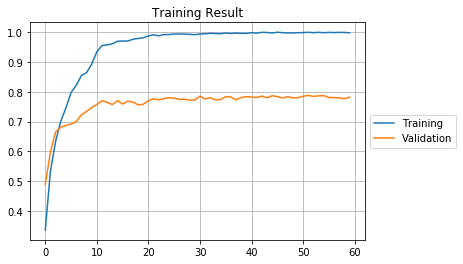

In [8]:
""" Visualizing Training Results """
fig, ax = plt.subplots()
plt.title("Training Result")

ax.plot(train_acc, label='Training')
ax.plot(eval_acc, label='Validation')

plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()